In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
from os import listdir
from os.path import isfile, join
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import multiprocessing
from collections import defaultdict

In [6]:
mypath = '../../data/MLgSA/wss/'
mypath1 = '../../data/MLgSA/New_wss/'

onlyfiles = np.asarray([f for f in listdir(mypath) if isfile(join(mypath, f))])
onlyfiles1 = np.asarray([f for f in listdir(mypath1) if isfile(join(mypath1, f))])

onlyfiles.sort()
onlyfiles1.sort()

print(len(onlyfiles), len(onlyfiles1))

short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])
short_list1 = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles1])
# short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])

109 50


In [3]:
df = pd.read_csv("../../data/MLgSA/stenosis_metadata.csv", sep=';')
# Matching the stenosis degree to the datasets
# missing datasets : index = [68, 87]
df = df.drop(index=[68, 87])
degree_list = df['ID'].values

In [11]:
meshes = []

for f in onlyfiles:
    reader = pv.get_reader(mypath + f)
    meshes.append(reader.read())
    
for f in onlyfiles1:
    reader = pv.get_reader(mypath1 + f)
    meshes.append(reader.read())

In [ ]:
i = 0
for t, (a,b) in enumerate(zip(degree_list, short_list)):
    if a != b:
        i = t
        print(i)
        print(degree_list[i], short_list[i])
        print(degree_list[i] in short_list)
        break

In [7]:
def vari(mesh):
    # Initialize a dictionary to store neighbors for each point
    neighbors = defaultdict(set)
    signal = mesh['non-directional_WSS_@_t=1.1']

    # Loop over each cell and populate the neighbors dictionary
    for i in range(mesh.n_cells):
        cell = mesh.get_cell(i)
        cell_points = cell.point_ids
        for i in range(len(cell_points)):
            for j in range(i + 1, len(cell_points)):
                neighbors[cell_points[i]].add(cell_points[j])
                neighbors[cell_points[j]].add(cell_points[i])


    # Visualize Total Variation by highlighting edges with largest differences
    # Initialize an array to store the total variation values
    total_variation = np.zeros(mesh.number_of_points)

    # Compute the total variation for each vertex
    for point_id in range(mesh.number_of_points):
        # Get the signal values at the point and its neighbors
        point_signal = signal[point_id]
        neighbor_signals = [signal[neighbor] for neighbor in neighbors[point_id]]
        # Calculate the total variation
        total_variation[point_id] = np.sum(np.abs(point_signal - np.array(neighbor_signals)))

    # Assign the total variation values to the mesh
    mesh.point_data['total_variation'] = total_variation

    max_var_indices = np.argsort(total_variation)[-30:]
    return mesh.extract_points(max_var_indices, include_cells=True)

In [11]:
for i in range(159):
    meshes[i] = vari(meshes[i])

In [12]:
# data stats
dl = []

for mesh in meshes:
    dl.append(np.asarray(mesh.point_data.values()[1]))

data = np.concatenate(dl)
mins = np.min(data)
maxs = np.max(data)
print(mins, maxs, maxs - mins)

0.10447378903196933 1674.871828135934 1674.767354346902


In [14]:
def get_graph(mesh):
    node_array = mesh.points
    n = node_array.shape[0]
    rows = []
    cols = []
    
    features = (np.asarray(mesh.point_data['non-directional_WSS_@_t=1.1']).T - mins)/(maxs - mins)

    for i in range(mesh.number_of_cells):
        cell = mesh.get_cell(i)
        cell_points = cell.point_ids
        n_points = len(cell_points)
        for j in range(n_points):
            for k in range(j + 1, n_points):
                p1 = cell_points[j]
                p2 = cell_points[k]
                rows.append(p1)
                cols.append(p2)
                rows.append(p2)
                cols.append(p1)  


    adj_matrix_coo = coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(mesh.number_of_points, mesh.number_of_points))
    edges = list(zip(adj_matrix_coo.row, adj_matrix_coo.col))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    
    return edge_index, n, torch.tensor(features, dtype=torch.float32).view((-1,1)), torch.tensor(mesh.points, dtype=torch.float32)

In [15]:
edjl = []
numl = []
nf = []
pos = []

p = multiprocessing.Pool(8)

for j, m in enumerate(meshes):
    edj, num, fe, po = get_graph(m)
    edjl.append(edj)
    numl.append(num)
    nf.append(fe)
    pos.append(po)

p.close()
p.join()


In [16]:
torch.save(edjl, '../../data/MLgSA/edge_indices.pt')
torch.save(numl, '../../data/MLgSA/nodes.pt')
torch.save(nf, '../../data/MLgSA/node_features.pt')
torch.save(pos, '../../data/MLgSA/pos.pt')

In [17]:
sten = df['Stenosis Degree'].values
ys = [0 if i<50. else 1 for i in sten]

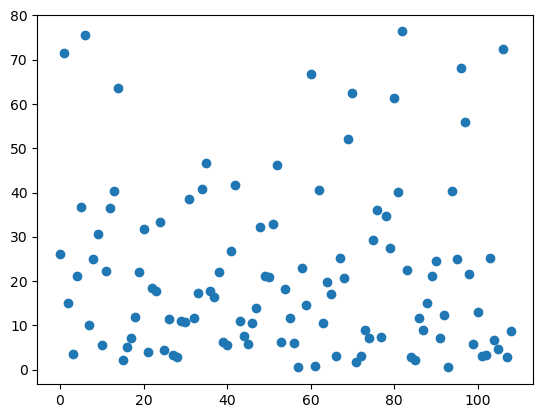

In [18]:
plt.scatter(range(109), sten)

In [19]:
np.count_nonzero(ys)

11

In [20]:
new_ys = ys + [1]*50

print(len(new_ys) == len(meshes))

True


In [21]:
new_ys = torch.tensor(new_ys, dtype=torch.long)

In [22]:
torch.save(new_ys, '../../data/MLgSA/classes.pt')

In [23]:
dataset = [Data(x = a, edge_index=b, y = y, pos=posns) for (a, b, y, posns) in zip(nf, edjl, new_ys, pos)]


In [24]:
torch.save(dataset, '../../data/MLgSA/dataset.pt')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(dataset, new_ys,
                                                    stratify=new_ys,
                                                    test_size=0.25)

In [26]:
torch.save(X_train, '../../data/MLgSA/train_split.pt')
torch.save(X_test, '../../data/MLgSA/test_split.pt')

In [35]:
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)


torch.save(train_loader, '../../data/MLgSA/train_loader.pt')


NameError: name 'X_train' is not defined

In [36]:
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)
torch.save(test_loader, '../../data/MLgSA/test_loader.pt')

In [12]:
dataset = torch.load('../../data/MLgSA/dataset.pt')
numl = torch.load ('../../data/MLgSA/nodes.pt')
len(numl)

159

In [19]:
crosslist = [[o.x.shape[0],n.n_points] for (o,n) in zip(dataset, meshes)]

In [30]:
import csv


with open('test.csv', 'w') as test_file:
  file_writer = csv.writer(test_file)
  for row in crosslist:
    file_writer.writerow(row)

In [34]:
for i, d in enumerate(dataset):
    if d.x.shape[0] == 110:
        print(i, d.edge_index.shape)

37 torch.Size([2, 762])
70 torch.Size([2, 768])
72 torch.Size([2, 786])
156 torch.Size([2, 792])


In [31]:
X_test = torch.load('../../data/MLgSA/test_split.pt')

In [32]:
X_test

[Data(x=[79, 1], edge_index=[2, 642], y=0, pos=[79, 3]),
 Data(x=[148, 1], edge_index=[2, 930], y=0, pos=[148, 3]),
 Data(x=[104, 1], edge_index=[2, 768], y=1, pos=[104, 3]),
 Data(x=[110, 1], edge_index=[2, 768], y=1, pos=[110, 3]),
 Data(x=[121, 1], edge_index=[2, 858], y=0, pos=[121, 3]),
 Data(x=[129, 1], edge_index=[2, 858], y=0, pos=[129, 3]),
 Data(x=[90, 1], edge_index=[2, 690], y=0, pos=[90, 3]),
 Data(x=[119, 1], edge_index=[2, 804], y=1, pos=[119, 3]),
 Data(x=[87, 1], edge_index=[2, 666], y=0, pos=[87, 3]),
 Data(x=[116, 1], edge_index=[2, 816], y=1, pos=[116, 3]),
 Data(x=[120, 1], edge_index=[2, 858], y=0, pos=[120, 3]),
 Data(x=[107, 1], edge_index=[2, 744], y=0, pos=[107, 3]),
 Data(x=[136, 1], edge_index=[2, 924], y=1, pos=[136, 3]),
 Data(x=[94, 1], edge_index=[2, 720], y=1, pos=[94, 3]),
 Data(x=[52, 1], edge_index=[2, 480], y=0, pos=[52, 3]),
 Data(x=[115, 1], edge_index=[2, 786], y=1, pos=[115, 3]),
 Data(x=[140, 1], edge_index=[2, 900], y=0, pos=[140, 3]),
 Data(x